# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [1]:
import scanpy as sc
import celltypist
from celltypist import models
import json

## Download a scRNA-seq dataset of 2,000 immune cells

In [2]:
config_json = r"/mnt/work/RO_src/Pipelines/STNav/configs/analysis_cloud.json"
# Open config json with json.load
config_total = json.load(open(config_json, 'r'))
config = config_total["ST"]


In [16]:
adata_st = sc.read_visium(
	path=config["path"],
	count_file=config["count_file"],
	load_images=config["load_images"],
	source_image_path=config["source_image_path"],
)

adata_st.var_names_make_unique()


/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/scanpy/readwrite.py:415: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(files["tissue_positions_file"], header=None)


In [4]:
sc.pp.normalize_total(adata_st, target_sum = 1e4)
sc.pp.log1p(adata_st)

This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [5]:
adata_2000 = sc.read_h5ad(r"/mnt/work/RO_src/data/processed/PipelineRun_2024_06_15-09_33_10_AM/scRNA/Files/raw_adata.h5ad")
adata_2000.var_names_make_unique()


In [11]:
adata_2000.shape

(1786, 33567)

In [15]:
adata_2000.raw.X[10,20:60].toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         0.]], dtype=float32)

In [16]:
adata_2000.X = adata_2000.raw.X

In [19]:
adata_2000.X[10,20:60].toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         0.]], dtype=float32)

In [20]:
sc.pp.normalize_total(adata_2000)
adata_2000.X.expm1().sum(axis = 1)

matrix([[4.0496604e+07],
        [7.7816237e+08],
        [4.0178189e+22],
        ...,
        [          inf],
        [1.5024306e+20],
        [          inf]], dtype=float32)

In [21]:
sc.pp.log1p(adata_2000)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [22]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[1647.5001],
        [1647.5   ],
        [1647.4999],
        ...,
        [1647.4998],
        [1647.5   ],
        [1647.4999]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [23]:
adata_2000.obs

,dataset,ann_level_1_transferred_label_unfiltered,ann_level_2_transferred_label_unfiltered,ann_level_3_transferred_label_unfiltered,ann_level_4_transferred_label_unfiltered,ann_level_5_transferred_label_unfiltered,ann_level_1_transfer_uncert,ann_level_2_transfer_uncert,ann_level_3_transfer_uncert,ann_level_4_transfer_uncert,ann_level_5_transfer_uncert,ann_level_1_transferred_label,ann_level_2_transferred_label,ann_level_3_transferred_label,ann_level_4_transferred_label,ann_level_5_transferred_label
AAGCGTTTCAGTGCGC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,0.0,0.0,0.4800090317448792,0.4800090317448792,0.4800090317448792,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
AGCCACGAGGAGTCTG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,0.0,0.0,0.40002563472462294,0.40002563472462294,0.40002563472462294,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
ATCATTCGTATTTCGG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,1.1102230246251565e-16,1.1102230246251565e-16,0.3999594533637415,0.3999594533637415,0.3999594533637415,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
TGGCGTGCATGTAACC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,1.1102230246251565e-16,1.1102230246251565e-16,0.09990306748130084,0.09990306748130084,0.09990306748130084,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature
CTACAGACACTGTGAT,test_dataset_delorey_regev,Endothelial,Blood vessels,EC venous,EC venous systemic,4_EC venous systemic,0.0,0.0,0.0,0.0,0.0,Endothelial,Blood vessels,EC venous,EC venous systemic,4_EC venous systemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATGCACATGGGCAA,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1
AATGACCAGCCGATTT,test_dataset_delorey_regev,Immune,Lymphoid,T cell lineage,CD8 T cells,4_CD8 T cells,0.0,0.0,0.039995263051764596,0.039995263051764596,0.039995263051764596,Immune,Lymphoid,T cell lineage,CD8 T cells,4_CD8 T cells
CTCCATGCACTCTAGA,test_dataset_delorey_regev,Stroma,Fibroblast lineage,Fibroblasts,Adventitial fibroblasts,4_Adventitial fibroblasts,0.0,0.019994345142129055,0.019994345142129055,0.29997428336936705,0.29997428336936705,Stroma,Fibroblast lineage,Fibroblasts,Unknown,Unknown
ATGGGTTAGAGGCGTT,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,0.01998569928506244,0.01998569928506244,0.01998569928506244,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [6]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 48
📂 Storing models in /home/rafaed/.celltypist/data/models
💾 Downloading model [1/48]: Immune_All_Low.pkl
💾 Downloading model [2/48]: Immune_All_High.pkl
💾 Downloading model [3/48]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/48]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/48]: Adult_Human_Skin.pkl
💾 Downloading model [6/48]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/48]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/48]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/48]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/48]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/48]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/48]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/48]: Cells_Adult_Breast.pkl
💾 Downloading model [14/48]: Cells_Fetal_Lung.pkl
💾 Downloading model [15/48]: Cells_Human_Tonsil.pkl
💾

All models are stored in `models.models_path`.

In [ ]:
models.models_path

Get an overview of the models and what they represent.

In [25]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
3,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
4,Adult_Human_Skin.pkl,cell types from human healthy adult skin
5,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
6,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice
7,Adult_Pig_Hippocampus.pkl,cell types from the adult pig hippocampus
8,Adult_RhesusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult rhesu...
9,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [7]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Human_Lung_Atlas.pkl')

Show the model meta information.

In [8]:
adata_2000.obs["ann_level_3_transferred_label"]

AAGCGTTTCAGTGCGC                Unknown
AGCCACGAGGAGTCTG                Unknown
ATCATTCGTATTTCGG                Unknown
TGGCGTGCATGTAACC    Lymphatic EC mature
CTACAGACACTGTGAT              EC venous
                           ...         
TGATGCACATGGGCAA                    AT1
AATGACCAGCCGATTT         T cell lineage
CTCCATGCACTCTAGA            Fibroblasts
ATGGGTTAGAGGCGTT                    AT1
CGTGTCTCACGCTGTG           EC capillary
Name: ann_level_3_transferred_label, Length: 1786, dtype: category
Categories (16, object): ['2_Smooth muscle', 'AT1', 'AT2', 'B cell lineage', ..., 'Mast cells', 'Monocytes', 'T cell lineage', 'Unknown']

In [27]:
model

CellTypist model with 61 cell types and 5017 features
    date: 2023-05-17 19:51:55.661237
    details: integrated Human Lung Cell Atlas (HLCA) combining multiple datasets of the healthy respiratory system
    source: https://doi.org/10.1038/s41591-023-02327-2
    version: v2
    cell types: AT0, AT1, ..., pre-TB secretory
    features: TSPAN6, FGR, ..., RP1-34B20.21

This model contains 98 cell states.

In [28]:
model.cell_types

array(['AT0', 'AT1', 'AT2', 'AT2 proliferating',
       'Adventitial fibroblasts', 'Alveolar Mph CCL3+',
       'Alveolar Mph MT-positive', 'Alveolar Mph proliferating',
       'Alveolar fibroblasts', 'Alveolar macrophages', 'B cells',
       'Basal resting', 'CD4 T cells', 'CD8 T cells',
       'Classical monocytes', 'Club (nasal)', 'Club (non-nasal)', 'DC1',
       'DC2', 'Deuterosomal', 'EC aerocyte capillary', 'EC arterial',
       'EC general capillary', 'EC venous pulmonary',
       'EC venous systemic', 'Goblet (bronchial)', 'Goblet (nasal)',
       'Goblet (subsegmental)', 'Hematopoietic stem cells',
       'Hillock-like', 'Interstitial Mph perivascular', 'Ionocyte',
       'Lymphatic EC differentiating', 'Lymphatic EC mature',
       'Lymphatic EC proliferating', 'Mast cells', 'Mesothelium',
       'Migratory DCs', 'Monocyte-derived Mph', 'Multiciliated (nasal)',
       'Multiciliated (non-nasal)', 'Myofibroblasts', 'NK cells',
       'Neuroendocrine', 'Non-classical monocytes

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [9]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_2000, model = 'Human_Lung_Atlas.pkl', majority_voting = True,mode = 'best match')

ValueError: 🛑 Invalid expression matrix in both `.X` and `.raw.X`, expect log1p normalized expression to 10000 counts per cell

By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [34]:
predictions.predicted_labels["predicted_labels"].value_counts()

predicted_labels
AT2    1786
Name: count, dtype: int64

Transform the prediction result into an `AnnData`.

In [35]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata(insert_prob = True)

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [36]:
adata.obs

,dataset,ann_level_1_transferred_label_unfiltered,ann_level_2_transferred_label_unfiltered,ann_level_3_transferred_label_unfiltered,ann_level_4_transferred_label_unfiltered,ann_level_5_transferred_label_unfiltered,ann_level_1_transfer_uncert,ann_level_2_transfer_uncert,ann_level_3_transfer_uncert,ann_level_4_transfer_uncert,...,SMG mucous,SMG serous (bronchial),SMG serous (nasal),Smooth muscle,Smooth muscle FAM83D+,Subpleural fibroblasts,Suprabasal,T cells proliferating,Tuft,pre-TB secretory
AAGCGTTTCAGTGCGC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,0.0,0.0,0.4800090317448792,0.4800090317448792,...,0.000095,0.000111,0.000114,0.000112,0.000106,0.000106,0.000231,0.000102,0.000098,0.000109
AGCCACGAGGAGTCTG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,0.0,0.0,0.40002563472462294,0.40002563472462294,...,0.000092,0.000107,0.000111,0.000108,0.000105,0.000107,0.000230,0.000101,0.000097,0.000114
ATCATTCGTATTTCGG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,1.1102230246251565e-16,1.1102230246251565e-16,0.3999594533637415,0.3999594533637415,...,0.000095,0.000112,0.000114,0.000113,0.000106,0.000106,0.000231,0.000102,0.000099,0.000108
TGGCGTGCATGTAACC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,1.1102230246251565e-16,1.1102230246251565e-16,0.09990306748130084,0.09990306748130084,...,0.000093,0.000109,0.000112,0.000110,0.000106,0.000106,0.000230,0.000101,0.000098,0.000112
CTACAGACACTGTGAT,test_dataset_delorey_regev,Endothelial,Blood vessels,EC venous,EC venous systemic,4_EC venous systemic,0.0,0.0,0.0,0.0,...,0.000095,0.000111,0.000114,0.000112,0.000106,0.000106,0.000231,0.000102,0.000098,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATGCACATGGGCAA,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,...,0.000097,0.000115,0.000116,0.000116,0.000106,0.000106,0.000231,0.000103,0.000099,0.000106
AATGACCAGCCGATTT,test_dataset_delorey_regev,Immune,Lymphoid,T cell lineage,CD8 T cells,4_CD8 T cells,0.0,0.0,0.039995263051764596,0.039995263051764596,...,0.000097,0.000115,0.000116,0.000116,0.000106,0.000106,0.000231,0.000103,0.000099,0.000106
CTCCATGCACTCTAGA,test_dataset_delorey_regev,Stroma,Fibroblast lineage,Fibroblasts,Adventitial fibroblasts,4_Adventitial fibroblasts,0.0,0.019994345142129055,0.019994345142129055,0.29997428336936705,...,0.000097,0.000115,0.000116,0.000116,0.000106,0.000106,0.000231,0.000103,0.000099,0.000106
ATGGGTTAGAGGCGTT,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,0.01998569928506244,0.01998569928506244,...,0.000097,0.000115,0.000116,0.000116,0.000106,0.000106,0.000231,0.000103,0.000099,0.000106


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [31]:
import matplotlib.pyplot as plt


In [ ]:
list(adata.obs.predicted_labels)

In [ ]:
adata.obs.columns

In [ ]:
for cell_type in list(adata.obs.columns[7:]):
	if cell_type != "Unassigned":
		save_path =r"C:\Users\rafaelo\OneDrive - NTNU\Documents\Projects\STNav\notebooks\experimental\\" + cell_type + ".png"
		with plt.rc_context():  # Use this to set figure params like size and dpi
			plot_func = sc.pl.spatial(
				adata,
				cmap="magma",
				color=cell_type,
				img_key="hires",
				size=1.5,
				alpha_img=0.5,
				show=False,
			)
			plt.savefig(save_path, bbox_inches="tight")


In [ ]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

In [ ]:
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [10]:
adata_2000 = sc.read(r'/mnt/work/RO_src/data/processed/PipelineRun_2024_06_15-09_33_10_AM/scRNA/Files/raw_adata.h5ad')

Download another scRNA-seq dataset of 400 immune cells as a query.

In [ ]:
adata_400 = sc.read('celltypist_demo_folder/demo_400_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_400_cells.h5ad')

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) function.

In [11]:
sc.pp.normalize_total(adata_2000, target_sum = 1e4)
sc.pp.log1p(adata_2000)

In [44]:
adata_2000.obs

,dataset,ann_level_1_transferred_label_unfiltered,ann_level_2_transferred_label_unfiltered,ann_level_3_transferred_label_unfiltered,ann_level_4_transferred_label_unfiltered,ann_level_5_transferred_label_unfiltered,ann_level_1_transfer_uncert,ann_level_2_transfer_uncert,ann_level_3_transfer_uncert,ann_level_4_transfer_uncert,ann_level_5_transfer_uncert,ann_level_1_transferred_label,ann_level_2_transferred_label,ann_level_3_transferred_label,ann_level_4_transferred_label,ann_level_5_transferred_label
AAGCGTTTCAGTGCGC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,0.0,0.0,0.4800090317448792,0.4800090317448792,0.4800090317448792,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
AGCCACGAGGAGTCTG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,0.0,0.0,0.40002563472462294,0.40002563472462294,0.40002563472462294,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
ATCATTCGTATTTCGG,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC differentiating,3_Lymphatic EC differentiating,3_Lymphatic EC differentiating,1.1102230246251565e-16,1.1102230246251565e-16,0.3999594533637415,0.3999594533637415,0.3999594533637415,Endothelial,Lymphatic EC,Unknown,Unknown,Unknown
TGGCGTGCATGTAACC,test_dataset_delorey_regev,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature,1.1102230246251565e-16,1.1102230246251565e-16,0.09990306748130084,0.09990306748130084,0.09990306748130084,Endothelial,Lymphatic EC,Lymphatic EC mature,3_Lymphatic EC mature,3_Lymphatic EC mature
CTACAGACACTGTGAT,test_dataset_delorey_regev,Endothelial,Blood vessels,EC venous,EC venous systemic,4_EC venous systemic,0.0,0.0,0.0,0.0,0.0,Endothelial,Blood vessels,EC venous,EC venous systemic,4_EC venous systemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATGCACATGGGCAA,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,1.1102230246251565e-16,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1
AATGACCAGCCGATTT,test_dataset_delorey_regev,Immune,Lymphoid,T cell lineage,CD8 T cells,4_CD8 T cells,0.0,0.0,0.039995263051764596,0.039995263051764596,0.039995263051764596,Immune,Lymphoid,T cell lineage,CD8 T cells,4_CD8 T cells
CTCCATGCACTCTAGA,test_dataset_delorey_regev,Stroma,Fibroblast lineage,Fibroblasts,Adventitial fibroblasts,4_Adventitial fibroblasts,0.0,0.019994345142129055,0.019994345142129055,0.29997428336936705,0.29997428336936705,Stroma,Fibroblast lineage,Fibroblasts,Unknown,Unknown
ATGGGTTAGAGGCGTT,test_dataset_delorey_regev,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1,1.1102230246251565e-16,1.1102230246251565e-16,0.01998569928506244,0.01998569928506244,0.01998569928506244,Epithelial,Alveolar epithelium,AT1,3_AT1,3_AT1


In [45]:
adata_2000.obs["ann_level_3_transferred_label"].value_counts()

ann_level_3_transferred_label
Fibroblasts                     1068
EC capillary                     214
EC venous                        149
Unknown                          138
T cell lineage                    63
AT1                               60
Lymphatic EC differentiating      22
Macrophages                       18
Lymphatic EC mature               15
B cell lineage                     9
AT2                                7
2_Smooth muscle                    6
EC arterial                        6
Mast cells                         6
Innate lymphoid cell NK            4
Monocytes                          1
Name: count, dtype: int64

In [46]:
adata_st

AnnData object with n_obs × n_vars = 605471 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [12]:
adata_2000.var_names = adata_2000.var_names.str.upper()

In [13]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'ann_level_3_transferred_label', n_jobs = 10, feature_selection = True, epochs = 15000)

🍳 Preparing data before training
✂️ 14312 non-expressed genes are filtered out
🔬 Input data has 1786 cells and 19255 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 3241 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [ ]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [ ]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

In [17]:
len(new_model.features)

3252

In [49]:
adata_2000.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'SARSCOV2_SARSCOV2_E', 'SARSCOV2_SARSCOV2_M', 'SARSCOV2_SARSCOV2_ORF6',
       'SARSCOV2_SARSCOV2_ORF7A', 'SARSCOV2_SARSCOV2_ORF7B',
       'SARSCOV2_SARSCOV2_ORF8', 'SARSCOV2_SARSCOV2_N',
       'SARSCOV2_SARSCOV2_ORF10', 'SARSCOV2_SARSCOV2_3PRIME',
       'SARSCOV2_SARSCOV2_NEGSTRAND'],
      dtype='object', length=33567)

In [17]:
adata_st.var

,gene_ids,feature_types,genome
SAMD11,ENSG00000187634,Gene Expression,GRCh38
NOC2L,ENSG00000188976,Gene Expression,GRCh38
KLHL17,ENSG00000187961,Gene Expression,GRCh38
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38
PERM1,ENSG00000187642,Gene Expression,GRCh38
...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38
MT-ND4,ENSG00000198886,Gene Expression,GRCh38
MT-ND5,ENSG00000198786,Gene Expression,GRCh38
MT-ND6,ENSG00000198695,Gene Expression,GRCh38


Next, we use this model to predict the query dataset of 400 immune cells.

In [51]:
new_model.features

array(['AL645608.8', 'ISG15', 'TTLL10', ..., '21ORF58', 'MT-CO1',
       'AC011043.1'], dtype=object)

In [18]:
sc.pp.normalize_total(adata_st, target_sum = 1e4)
sc.pp.log1p(adata_st)

In [17]:
# Add spatial connectivities4
import squidpy as sq
from scipy.sparse import csr_matrix
sq.gr.spatial_neighbors(adata_st)

adata_st.obsp["spatial_connectivities"] = csr_matrix(
	adata_st.obsp["spatial_connectivities"]
)

adata_st.X = adata_st.obsp["spatial_connectivities"].dot(adata_st.X)

In [19]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_st, model = new_model, majority_voting = True)

🔬 Input data has 605471 cells and 18085 genes


🔗 Matching reference genes in the model
🧬 1791 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/mnt/work/RO_src/venv/stnav_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-22 10:43:08.053898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-22 10:43:08.053990: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [20]:
predictions.adata

AnnData object with n_obs × n_vars = 605471 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatial_neighbors', 'log1p', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    obsp: 'spatial_connectivities', 'spatial_distances', 'connectivities', 'distances'

In [21]:
adata = predictions.to_adata().copy()

In [29]:
sc.tl.umap(adata)

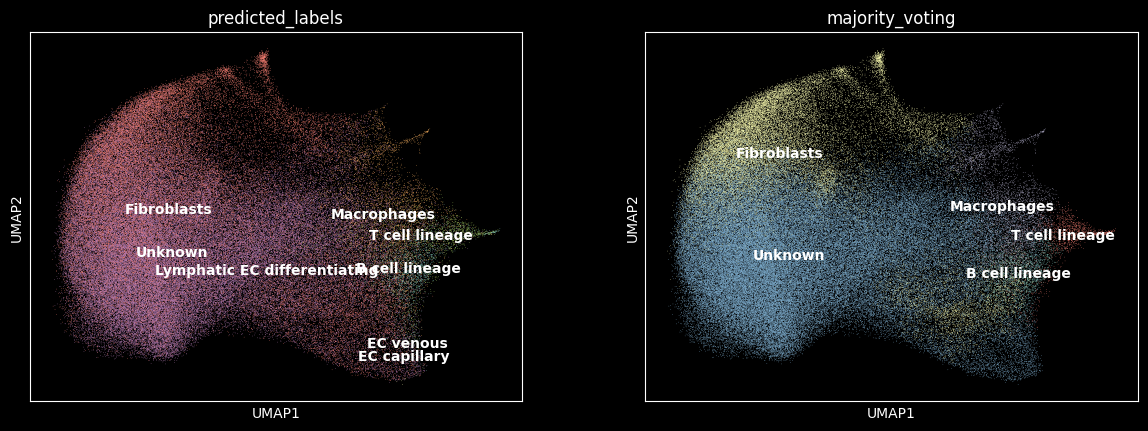

In [30]:
sc.pl.umap(adata, color = [ 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

ModuleNotFoundError: No module named 'matplotlib.plt'

In [31]:
adata.obs["in_tissue"] = adata.obs["in_tissue"].astype(int)
adata.obs["array_row"] = adata.obs["array_row"].astype(int)
adata.obs["array_col"] = adata.obs["array_col"].astype(dtype=int)
adata.obsm["spatial"] = adata.obsm["spatial"].astype(dtype=float)

In [32]:
adata.write_h5ad("cell_typist_adata.h5ad")

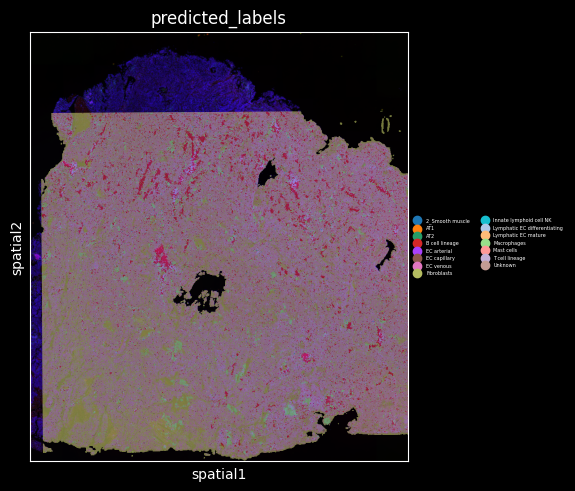

: 

In [40]:
import squidpy as sq
import matplotlib.pyplot as plt

sq.pl.spatial_scatter(
	adata,
	color="predicted_labels",
	shape="square",
	size=1,
	legend_fontsize=3.5,  # adjust this value to make the legend smaller
)
plt.savefig(f"cell_typist_scatter.png", dpi=1000)


In [22]:
adata.obs

,in_tissue,array_row,array_col,predicted_labels,over_clustering,majority_voting,conf_score
s_008um_00301_00321-1,1,301,321,Lymphatic EC differentiating,2085,Unknown,0.003360
s_008um_00602_00290-1,1,602,290,B cell lineage,106,Unknown,0.003343
s_008um_00425_00829-1,1,425,829,Unknown,753,Unknown,0.244578
s_008um_00728_00006-1,1,728,6,Unknown,384,Unknown,0.955056
s_008um_00526_00291-1,1,526,291,Unknown,448,Unknown,0.021835
...,...,...,...,...,...,...,...
s_008um_00384_00793-1,1,384,793,Fibroblasts,611,Fibroblasts,0.067957
s_008um_00653_00166-1,1,653,166,Fibroblasts,987,Unknown,0.012021
s_008um_00565_00244-1,1,565,244,T cell lineage,39,Unknown,0.134479
s_008um_00353_00477-1,1,353,477,Fibroblasts,912,Unknown,0.060466


In [24]:
import pandas as pd

In [25]:
# Convert 'predicted_labels' into dummy variables
dummies = pd.get_dummies(adata.obs['predicted_labels'])

# Convert True/False to 1/0
dummies = dummies.astype(int)

# Add the dummy variables to the original DataFrame
adata.obs = pd.concat([adata.obs, dummies], axis=1)

In [26]:
adata.obs["predicted_labels"].value_counts()

predicted_labels
Unknown                         88849
Fibroblasts                     51720
Macrophages                      6834
B cell lineage                   2288
T cell lineage                   2189
EC capillary                       92
EC venous                          58
Lymphatic EC differentiating        9
AT2                                 5
2_Smooth muscle                     3
Mast cells                          1
Name: count, dtype: int64

In [27]:
adata.obs

,in_tissue,array_row,array_col,predicted_labels,over_clustering,majority_voting,conf_score,2_Smooth muscle,AT2,B cell lineage,EC capillary,EC venous,Fibroblasts,Lymphatic EC differentiating,Macrophages,Mast cells,T cell lineage,Unknown
s_016um_00052_00082-1,1,52,82,Unknown,17,Macrophages,0.267002,0,0,0,0,0,0,0,0,0,0,1
s_016um_00010_00367-1,1,10,367,Fibroblasts,70,Fibroblasts,0.497584,0,0,0,0,0,1,0,0,0,0,0
s_016um_00163_00399-1,1,163,399,Unknown,76,Fibroblasts,0.003395,0,0,0,0,0,0,0,0,0,0,1
s_016um_00238_00388-1,1,238,388,Unknown,312,Fibroblasts,0.895297,0,0,0,0,0,0,0,0,0,0,1
s_016um_00144_00175-1,1,144,175,Unknown,1134,Unknown,0.335700,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_016um_00375_00231-1,1,375,231,Fibroblasts,33,Unknown,0.083340,0,0,0,0,0,1,0,0,0,0,0
s_016um_00109_00223-1,1,109,223,Unknown,654,Unknown,0.455849,0,0,0,0,0,0,0,0,0,0,1
s_016um_00039_00175-1,1,39,175,Unknown,75,Unknown,0.134591,0,0,0,0,0,0,0,0,0,0,1
s_016um_00037_00193-1,1,37,193,Macrophages,17,Macrophages,0.518244,0,0,0,0,0,0,0,1,0,0,0


In [34]:
import pandas as pd 
import numpy as np
from matplotlib import plt

ImportError: cannot import name 'plt' from 'matplotlib' (c:\Users\rafaelo\OneDrive - NTNU\Documents\Projects\venv\lib\site-packages\matplotlib\__init__.py)

In [32]:
list(set(list(adata.obs["predicted_labels"])))

['EC capillary',
 'Macrophages',
 '2_Smooth muscle',
 'Fibroblasts',
 'Lymphatic EC differentiating',
 'Mast cells',
 'AT2',
 'Unknown',
 'B cell lineage',
 'EC venous',
 'T cell lineage']

In [35]:
import matplotlib.pyplot as plt


In [11]:
for cell_type in list(set(list(adata.obs["predicted_labels"]))):
	save_path =r"C:\Users\rafaelo\OneDrive - NTNU\Documents\Projects\STNav\notebooks\experimental\\" + cell_type + ".png"
	with plt.rc_context():  # Use this to set figure params like size and dpi
		plot_func = sc.pl.spatial(
			adata,
			cmap="magma",
			color=cell_type,
			img_key="hires",
			size=1.5,
			alpha_img=0.5,
			show=False,
		)
		plt.savefig(save_path, bbox_inches="tight")

NameError: name 'adata' is not defined

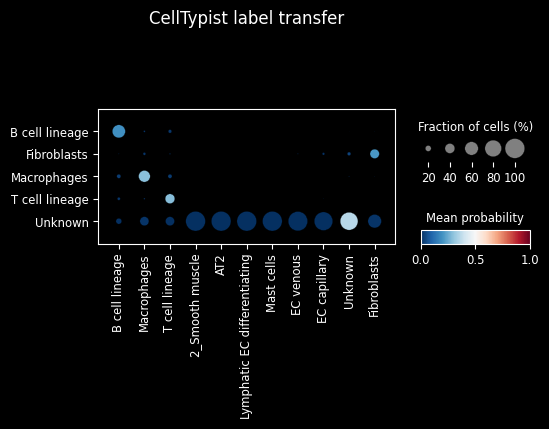

In [37]:
celltypist.dotplot(predictions, use_as_reference = 'predicted_labels', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [ ]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [13]:
new_model.cell_types

array(['2_Smooth muscle', 'AT1', 'AT2', 'B cell lineage', 'EC arterial',
       'EC capillary', 'EC venous', 'Fibroblasts',
       'Innate lymphoid cell NK', 'Lymphatic EC differentiating',
       'Lymphatic EC mature', 'Macrophages', 'Mast cells', 'Monocytes',
       'T cell lineage', 'Unknown'], dtype=object)

Extract the top three driving genes of `Mast cells` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [ ]:
model.cell_types

In [15]:
import pandas as pd

In [14]:
# Train model with atlas and ann level 1 annotation with less granular data
new_model = celltypist.train(adata_2000, labels = 'ann_level_3_transferred_label', n_jobs = 10, feature_selection = True, epochs = 15000)


🍳 Preparing data before training
✂️ 14312 non-expressed genes are filtered out
🔬 Input data has 1786 cells and 19255 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 3253 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [16]:
import pandas as pd

In [22]:
top_cell_markers = {}
num_list = []
markers = []
for cell in new_model.cell_types:
    top_10_current = new_model.extract_top_markers(cell, 4)
    num_list += [cell] * len(top_10_current)
    markers += list(top_10_current)

# Create DataFrame
df = pd.DataFrame({
    'Gene name': markers,
    'Function': num_list,
})

In [8]:
top_cell_markers

{'List': ['pre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretorypre-TB secretory'],
 'Markers': array(['SFTPB', 'SCGB3A2', 'SCGB1A1', 'SCGB3A1', 'RNASE1', 'SAA1',
        'CYB5A', 'SSUH2', 'CLU', 'GPR182'], dtype=object)}

In [6]:
top_3_genes = model.extract_top_markers("Mast cells", 3)
top_3_genes

array(['TPSAB1', 'TPSB2', 'NTRK1'], dtype=object)

In [40]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

ValueError: adata.raw.var_names contains duplicated items
Please rename these var names first for example using `adata.var_names_make_unique()`

In [ ]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)